In [1]:
%load_ext autoreload
%autoreload 2

import pyVHR as vhr
import numpy as np
from pyVHR.analysis.pipeline import Pipeline
from pyVHR.plot.visualize import *
import os
import plotly.express as px
from pyVHR.utils.errors import getErrors, printErrors, displayErrors

import constants
import pandas as pd
import pyVHR.analysis.pipelineLandmarks as custom_pipeline
import steps 
from tqdm import tqdm

vhr.plot.VisualizeParams.renderer = 'vscode' 

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
import time
from importlib import import_module, util
from pyVHR.datasets.dataset import datasetFactory
from pyVHR.utils.errors import getErrors, printErrors, displayErrors, BVP_windowing
from pyVHR.extraction.sig_processing import *
from pyVHR.extraction.sig_extraction_methods import *
from pyVHR.extraction.skin_extraction_methods import *
from pyVHR.BVP.BVP import *
from pyVHR.BPM.BPM import *
from pyVHR.BVP.methods import *
from pyVHR.BVP.filters import *
from inspect import getmembers, isfunction
import os.path
from pyVHR.deepRPPG.mtts_can import *
from pyVHR.deepRPPG.hr_cnn import *
from pyVHR.extraction.utils import *
from dtw import *
from scipy import signal
import scipy

In [3]:
# -- LOAD A DATASET

dataset_name = 'lgi_ppgi'   
dataset = steps.get_dataset(dataset_name)
# dataset = steps.get_dataset(dataset_name, video_DIR=f'D:/datasets_rppg/brightness_140/{dataset_name.upper()}/')
# dataset = steps.get_dataset(dataset_name, video_DIR=f'D:/datasets_rppg/brightness_roi/lgi/{dataset_name.upper()}/')
allvideo = dataset.videoFilenames
videos = constants.get_video_settings(dataset_name)
print(videos)

# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])

{'GYM': array([ 0,  4,  8, 12, 16, 20]), 'STILL': array([ 1,  5,  9, 13, 17, 21]), 'ROTATION': array([ 2,  6, 10, 14, 18, 22]), 'TALK': array([ 3,  7, 11, 15, 19]), 'MALE': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23]), 'FEMALE': [0, 1, 2, 3], 'BEARD': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23]), 'GLASSES': [0, 1, 2, 3]}
0 D:/datasets_rppg/lgi_ppgi\alex\alex_gym\cv_camera_sensor_stream_handler.avi
1 D:/datasets_rppg/lgi_ppgi\alex\alex_resting\cv_camera_sensor_stream_handler.avi
2 D:/datasets_rppg/lgi_ppgi\alex\alex_rotation\cv_camera_sensor_stream_handler.avi
3 D:/datasets_rppg/lgi_ppgi\alex\alex_talk\cv_camera_sensor_stream_handler.avi
4 D:/datasets_rppg/lgi_ppgi\angelo\angelo_gym\cv_camera_sensor_stream_handler.avi
5 D:/datasets_rppg/lgi_ppgi\angelo\angelo_resting\cv_camera_sensor_stream_handler.avi
6 D:/datasets_rppg/lgi_ppgi\angelo\angelo_rotation\cv_camera_sensor_stream_handler.avi


In [4]:
# -- PARAMETER SETTING

winsize = 10       # seconds of video processed (with overlapping) for each estimate 
patch_size = constants.get_patch_size(dataset_name)
videoFPS, sigFPS = constants.get_fps(dataset_name)
print(f"Patch size for {dataset_name} is {patch_size} ")
print(f"Video fps for {dataset_name} is {videoFPS}, Signal fps is {sigFPS} ")

Patch size for lgi_ppgi is 40 
Video fps for lgi_ppgi is 25, Signal fps is 60 


videoFileName :  D:/datasets_rppg/lgi_ppgi\cpi\cpi_rotation\cv_camera_sensor_stream_handler.avi
Video frame rate:      25.0
Length of the video: 1:05 min, timesGT is 82 s
Signal frame rate is 60 fps for MR-NIRP and signal is  81.55 seconds worth


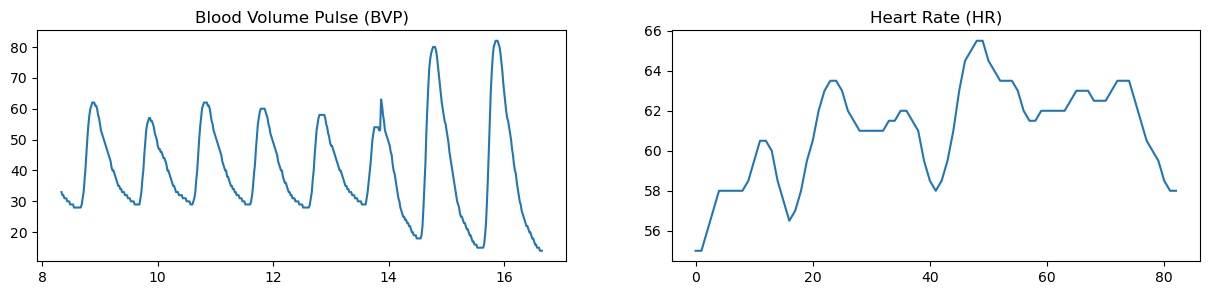

In [5]:
videoIdx = 10
fname = dataset.getSigFilename(videoIdx)
sigGT = dataset.readSigfile(fname)
bpmGT, timesGT = sigGT.getBPM(winsize) # STFT 42-240 BPM

videoFileName = dataset.getVideoFilename(videoIdx)
print("videoFileName : ", videoFileName)
fps = vhr.extraction.get_fps(videoFileName)
print('Video frame rate:     ',fps)
print(f"Length of the video: 1:05 min, timesGT is {len(timesGT)-1} s")
print("Signal frame rate is 60 fps for MR-NIRP and signal is ", sigGT.data.shape[1] / sigFPS, "seconds worth")

fig, ax = plt.subplots(1,2,figsize=(15,3))
ax[0].plot(np.arange(0, len(timesGT), 1/sigFPS)[500:1000], sigGT.data.T[500:1000])
ax[0].set_title('Blood Volume Pulse (BVP)')
ax[1].plot(timesGT, bpmGT)
ax[1].set_title('Heart Rate (HR)')
plt.show()

# Extract rPPG

In [6]:
minHz = 0.65
maxHz = 4.0
cuda=True,
roi_method='convexhull'
roi_approach='landmark' 
RGB_LOW_HIGH_TH = (0,240)
Skin_LOW_HIGH_TH = (0, 240)
pre_filt=True
post_filt=True 
verb=False

all_landmarks = vhr.extraction.utils.CustomLandmarks().get_all_landmarks()
all_landmarks = list(all_landmarks.keys()) # take all landmarks
print(f"all_landmarks: {all_landmarks}")

all_landmarks: ['lower_medial_forehead', 'left_lower_lateral_forehead', 'right_lower_lateral_forehead', 'glabella', 'upper_nasal_dorsum', 'lower_nasal_dorsum', 'soft_triangle', 'left_ala', 'right_ala', 'nasal_tip', 'left_lower_nasal_sidewall', 'right_lower_nasal_sidewall', 'left_mid_nasal_sidewall', 'right_mid_nasal_sidewall', 'philtrum', 'left_upper_lip', 'right_upper_lip', 'left_nasolabial_fold', 'right_nasolabial_fold', 'left_temporal', 'right_temporal', 'left_malar', 'right_malar', 'left_lower_cheek', 'right_lower_cheek', 'chin', 'left_marionette_fold', 'right_marionette_fold']


In [7]:
def run_extraction(ldmks_list, videoFileName, roi_approach, sampling_method='all', nb_sample_points=1500, roi_method='convexhull', seconds=0, verb=False):

    RGB_LOW_HIGH_TH=(0,240)
    Skin_LOW_HIGH_TH=(0, 240)
    cuda = True
    patch_size=40.0

    # test video filename
    assert os.path.isfile(videoFileName), "The video file does not exists!"
    if verb:
        print("Video: ", videoFileName)

    sig_processing = SignalProcessing()
    av_meths = getmembers(pyVHR.BVP.methods, isfunction)
    available_methods = [am[0] for am in av_meths]

    if cuda and verb:
        # sig_processing.display_cuda_device()
        sig_processing.choose_cuda_device(0)

    start_video = time.time()

    ## 1. set skin extractor
    target_device = 'GPU' if cuda else 'CPU'
    if roi_method == 'convexhull':
        sig_processing.set_skin_extractor(SkinExtractionConvexHull(target_device))
    elif roi_method == 'faceparsing':
        sig_processing.set_skin_extractor(SkinExtractionFaceParsing(target_device))
    else:
        raise ValueError("Unknown 'roi_method'")
            
    ## 2. set patches # CHANGED , suppose only custom landmarks
    if roi_approach == 'patches':
        if len(ldmks_list) == 0: # take all landmarks
            ldmks_list = [
                x for x in list(pyVHR.extraction.CustomLandmarks().__dict__)
            ]
        all_landmarks  = pyVHR.extraction.CustomLandmarks().get_all_landmarks()
        ldmk_values = list(np.unique(sum([all_landmarks[ldmk] for ldmk in ldmks_list], [])))
        sig_processing.set_landmarks(ldmk_values)
        sig_processing.set_square_patches_side(float(patch_size))
    if roi_approach == 'landmark':
        if len(ldmks_list) == 0: # take all landmarks
            ldmks_list = [
                x for x in list(pyVHR.extraction.CustomLandmarks().__dict__)
            ]
        all_landmarks  = pyVHR.extraction.CustomLandmarks().get_all_landmarks()
        ldmk_values = [all_landmarks[ldmk] for ldmk in ldmks_list]
        sig_processing.set_landmarks(ldmk_values)
        sig_processing.set_patch_sampling(sampling_method=sampling_method, nb_sample_points=nb_sample_points)


    if verb:
        print(f"Landmarks list : {ldmks_list}")

    # set sig-processing and skin-processing params
    SignalProcessingParams.RGB_LOW_TH = RGB_LOW_HIGH_TH[0]
    SignalProcessingParams.RGB_HIGH_TH = RGB_LOW_HIGH_TH[1]
    SkinProcessingParams.RGB_LOW_TH = Skin_LOW_HIGH_TH[0]
    SkinProcessingParams.RGB_HIGH_TH = Skin_LOW_HIGH_TH[1]

    if verb:
        print('\nProcessing Video ' + videoFileName)
    fps = get_fps(videoFileName)
    sig_processing.set_total_frames(seconds*fps)

    ## 3. ROI selection
    sig = []
    if roi_approach == 'holistic':
        # SIG extraction with holistic
        sig = sig_processing.extract_holistic(videoFileName)
    elif roi_approach == 'patches':
        # SIG extraction with patches
        sig = sig_processing.extract_patches(videoFileName, 'squares', 'mean')
    elif roi_approach == 'landmark':
        # SIG extraction with landmarks
        sig = sig_processing.extract_patches(videoFileName, 'landmark', 'mean')
    
    return sig
        
    # ## 4. sig windowing
    # windowed_sig, timesES = sig_windowing(sig, winsize, 1, fps)
    # if verb:
    #     print(f" - Extraction approach: {roi_approach} with {len(windowed_sig)} windows")
    
    # return windowed_sig, timesES

In [8]:
def add_data(landmark, videoFileName, sig, timesES, bpmGT, timesGT):
  
  data = {}
  data['dataset'] = dataset_name
  data['videoIdx'] = allvideo.index(videoFileName)
  if  dataset_name == 'mr_nirp':
    data['videoFilename'] = videoFileName.split('\\')[-1][:-4]
  if dataset_name == 'ubfc_phys':
    data['videoFilename'] = videoFileName.split('\\')[-1].split('_')[1]
  if dataset_name == 'lgi_ppgi':
    data['videoFilename'] = videoFileName.split('\\')[-2]
  data['landmark'] = landmark # single landmark
  data['bpmGT'] = bpmGT
  # data['PPG'] = sigGT.data # shape (1,n) # no windowing, no normalization
  # data['rPPG_windowed'] = windowed_sig # (windows, nb_keypoints, RGB, samples)
  data['rPPG'] = sig # (nb_keypoints, RGB, samples)
  data['timesGT'] = timesGT
  data['timesES'] = timesES

  return data

In [9]:
datas = []

for videoIdx in tqdm(range(len(allvideo))):
# for fileIdx in tqdm(videos['STILL']):
    # videoIdx = allvideo.index(allvideo[fileIdx])
    fname = dataset.getSigFilename(videoIdx)
    videoFileName = dataset.getVideoFilename(videoIdx)
    if dataset_name == 'ubfc_phys' and 'T1' not in videoFileName:
        continue
    if dataset_name == 'mr_nirp' and 'still' not in videoFileName:
        continue
    # if dataset_name == 'lgi_ppgi' and ('gym' not in videoFileName) :
    #     continue
    print(videoIdx, videoFileName)
    try:
        sigGT = dataset.readSigfile(fname)
        bpmGT, timesGT = sigGT.getBPM(winsize) # STFT 42-240 BPM
    except:
        print("Unusable video ", videoFileName)
        pass

    for landmark in all_landmarks:
        try:
            sig = run_extraction([landmark], videoFileName, roi_approach='landmark', sampling_method='random',seconds=60, nb_sample_points=2000)
            data = add_data(landmark, videoFileName, sig, None, bpmGT, timesGT)
            # windowed_sig, timesES = run_extraction([landmark], videoFileName, roi_approach='landmark', sampling_method='random',seconds=0, nb_sample_points=2000)
            # data = add_data(landmark, videoFileName, windowed_sig, timesES, bpmGT, timesGT)
            datas.append(data)
        except Exception as e:
            print("Error in landmark ", landmark, " for video ", videoFileName)
            print(e)
            pass

  0%|          | 0/24 [00:00<?, ?it/s]

0 D:/datasets_rppg/brightness_roi/lgi/LGI_PPGI/alex\alex_gym\cv_camera_sensor_stream_handler.avi


  4%|▍         | 1/24 [04:58<1:54:15, 298.05s/it]

4 D:/datasets_rppg/brightness_roi/lgi/LGI_PPGI/angelo\angelo_gym\cv_camera_sensor_stream_handler.avi
adjust


 21%|██        | 5/24 [10:18<35:38, 112.53s/it]  

8 D:/datasets_rppg/brightness_roi/lgi/LGI_PPGI/cpi\cpi_gym\cv_camera_sensor_stream_handler.avi


 38%|███▊      | 9/24 [15:42<23:49, 95.28s/it] 

12 D:/datasets_rppg/brightness_roi/lgi/LGI_PPGI/david\david_gym\cv_camera_sensor_stream_handler.avi


 54%|█████▍    | 13/24 [21:14<16:27, 89.82s/it]

16 D:/datasets_rppg/brightness_roi/lgi/LGI_PPGI/felix\felix_gym\cv_camera_sensor_stream_handler.avi
adjust


 71%|███████   | 17/24 [26:26<09:57, 85.32s/it]

20 D:/datasets_rppg/brightness_roi/lgi/LGI_PPGI/harun\harun_gym\cv_camera_sensor_stream_handler.avi


100%|██████████| 24/24 [31:39<00:00, 79.14s/it]


In [10]:
df = pd.DataFrame(datas)
df['sampling'] = 'lgi'
df.head()

,dataset,videoIdx,videoFilename,landmark,bpmGT,rPPG,timesGT,timesES,sampling
0,lgi_ppgi,0,alex_gym,lower_medial_forehead,"[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[[[0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0]], [[158.5...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,lgi
1,lgi_ppgi,0,alex_gym,left_lower_lateral_forehead,"[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[[[0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0]], [[152.9...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,lgi
2,lgi_ppgi,0,alex_gym,right_lower_lateral_forehead,"[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[[[0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0]], [[150.8...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,lgi
3,lgi_ppgi,0,alex_gym,glabella,"[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[[[0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0]], [[145.5...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,lgi
4,lgi_ppgi,0,alex_gym,upper_nasal_dorsum,"[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[[[0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0]], [[138.2...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,lgi


In [11]:
# df.to_hdf(f'../results/no_overlap/{dataset_name.upper()}/{dataset_name.upper()}_rPPG.h5', key='df', mode='w')
# df.to_hdf(f'../results/brightness_140/{dataset_name.upper()}/{dataset_name.upper()}_rPPG.h5', key='df', mode='w')
# df.to_hdf(f'../results/brightness_roi/lgi/{dataset_name.upper()}/{dataset_name.upper()}_rPPG_talk_60s.h5', key='df', mode='w')

C:\Users\erolland\AppData\Local\Temp\3\ipykernel_22328\301974329.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['dataset', 'videoFilename', 'landmark', 'bpmGT', 'rPPG', 'timesGT',
       'timesES', 'sampling'],
      dtype='object')]

  df.to_hdf(f'../results/brightness_roi/lgi/{dataset_name.upper()}/{dataset_name.upper()}_rPPG_talk_60s.h5', key='df', mode='w')
